# 𝔻𝕖𝕔𝕖𝕟𝕥ℕ𝕖𝕥: 𝕕𝕚𝕤𝕖𝕟𝕥𝕒𝕟𝕘𝕝𝕖𝕕 𝕟𝕖𝕥

Goal: create a sparse and modular ConvNet


Notes:
* additionally needed: position, activated channels, connection between channels
* within this layer, a whole filter can be deactivated
* within a filter, single channels can be deactivated
* within this layer, filters can be swapped
     
* pruning actually doesn"t work: https://discuss.pytorch.org/t/pruning-doesnt-affect-speed-nor-memory-for-resnet-101/75814   
* fine tune a pruned model: https://stackoverflow.com/questions/73103144/how-to-fine-tune-the-pruned-model-in-pytorch
* an actual pruning mechanism: https://arxiv.org/pdf/2002.08258.pdf

pip install:
* pytorch_lightning


warnings:
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned_state', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.

![uml of code](examples/example_vis/uml.png)

# imports

In [1]:
from __future__ import print_function


import os
import random
import math
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
from typing import Optional, List, Tuple, Union
from PIL import Image

from sklearn.model_selection import train_test_split
import scipy

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn.modules.module import Module
from torch.nn.modules.utils import _single, _pair, _triple, _reverse_repeat_tuple
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch._torch_docs import reproducibility_notes

from torchvision import datasets, transforms
import torchvision

import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import sys 
sys.path.insert(0, "helper")
from visualisation.feature_map import *

C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
torch.manual_seed(19)
torch.cuda.manual_seed(19)
random.seed(19)
np.random.seed(19)

print("cuda available:", torch.cuda.is_available())

debug_model = False

print('torch 2.0.0 ==', torch.__version__=='2.0.0')
print('tl 2.1.0 ==', pl.__version__=='2.1.0')

cuda available: True
torch 2.0.0 == True
tl 2.1.0 == True


# Settings

In [3]:
model_kwargs = {
    'n_classes': 10,
    'out_dim' :  [1, 4, 4, 4], # [1, 8, 16, 32], #[1, 16, 24, 32]
    'grid_size' : 18*18,
    'criterion': torch.nn.CrossEntropyLoss(),# torch.nn.BCEWithLogitsLoss(),
    'optimizer': "sgd", # sgd adamw
    'base_lr': 0.001,
    'min_lr' : 0.00001,
    'momentum' : 0.9,
    'lr_update' : 100,
    'cc_weight': 10,
    'cc_metric' : 'l2', # connection cost metric (for loss) - distance metric
    'ci_metric' : 'l2', # importance metric (for pruning)
    'update_every_nth_epoch' : 1, # 10
    'pretrain_epochs' : 1,
    'prune_keep' : 0.95, # 0.97, # in each epoch
    'prune_keep_total' : 0.5, # this number is not exact, depends on the prune_keep value
}

train_kwargs = {
    'result_path': "examples/example_results", # "example_results/lightning_logs", # not in use??
    'exp_name': "tmp_testi",
    'load_ckpt_file' : "xversion_22/checkpoints/epoch=0-unpruned=10942-val_f1=0.06.ckpt", # 'version_94/checkpoints/epoch=26-step=1080.ckpt', # change this for loading a file and using "test", if you want training, keep None
    'epochs': 2, # figure out whether this is including or excluding the pretrain epochs
    'img_size' : 28, #168, # keep mnist at original size, training didn't work when i increased the size ...
    'batch_size': 10, # 128, # the higher the batch_size the faster the training - every iteration adds A LOT OF comp cost
    'log_every_n_steps' : 4, # lightning default: 50 # needs to be bigger than the amount of steps in an epoch (based on trainset size and batchsize)
    # 'test_batch_size': 1,
    'device': "cuda",
    'num_workers' : 18, # 18, # 18 for computer, 0 for laptop
    'train_size' : 30, # total or percentage
    'test_size' : 30, # total or percentage
}

# DecentNet trial and error

## DataSet

In [4]:
if True:
    
    transform=transforms.Compose([
        #transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=train_kwargs["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    
    dataset = datasets.MNIST('examples/example_data', train=False, download=True, transform=transform)
    # val_set = datasets.MNIST('example_data', train=False, transform=transform)
    
    print(len(dataset))
    
    # Split the indices in a stratified way
    indices = np.arange(len(dataset))
    # train_indices, val_indices = train_test_split(indices, train_size=0.8, test_size=0.2, stratify=dataset.targets)
    train_indices, val_indices = train_test_split(indices, train_size=30, test_size=30, stratify=dataset.targets)
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)
    
    train_dataloader = torch.utils.data.DataLoader(train_subset, shuffle=True, batch_size=train_kwargs["batch_size"], num_workers=train_kwargs["num_workers"])
    val_dataloader = torch.utils.data.DataLoader(val_subset, shuffle=False, batch_size=train_kwargs["batch_size"], num_workers=train_kwargs["num_workers"]) # , persistent_workers=True)
    
    # batch size has to be 1
    xai_dataloader = torch.utils.data.DataLoader(val_subset, shuffle=False, batch_size=1, num_workers=train_kwargs["num_workers"]) # , persistent_workers=True)

10000


## X

In [5]:
class X:
    # =============================================================================
    #
    # an object with image representations and their positions
    # amout of channels need to have same length as m and n lists
    #
    # =============================================================================
    
    def __init__(self, data, ms_x, ns_x):
        self.data = data # list of tensors (image representations)
        self.ms_x = ms_x # list of integers (m position of each image representation)
        self.ns_x = ns_x # list of integers (n position of each image representation)
                
    def setter(self, data, ms_x, ns_x):
        self.data = data
        self.ms_x = ms_x
        self.ns_x = ns_x
        
    def getter(self):
        return self.data, self.m, self.n
    
    def __str__(self):
        return 'X(data: ' + str(self.data.shape) +' at positions: ms_x= ' + ', '.join(str(m.item()) for m in self.ms_x) + ', ns_x= ' + ', '.join(str(n.item()) for n in self.ns_x) + ')'
    __repr__ = __str__

  

## DecentFilter
* conv2d problem: https://stackoverflow.com/questions/61269421/expected-stride-to-be-a-single-integer-value-or-a-list-of-1-values-to-match-the

In [6]:
class DecentFilter(torch.nn.Module):
    # =============================================================================
    #
    # convolution happens in here
    # one filter has multiple channels (aka weights)
    #
    # =============================================================================
    
    def __init__(self, ms_in, ns_in, m_this, n_this,
                 kernel_size=3, 
                 stride=1, 
                 padding=0, 
                 padding_mode="zeros",
                 dilation=3, 
                 # transposed=None, 
                 device=None, 
                 dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        
        # padding
        padding = padding if isinstance(padding, str) else _pair(padding)
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")
        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        
         
        # convolution
        self.kernel_size = _pair(kernel_size)
        self.stride = stride
        self.padding_mode = padding_mode
        self.padding = padding
        self.dilation = _pair(dilation)
        #self.transposed = transposed
        
        # weights
        assert len(ms_in) == len(ns_in), "ms_in and ns_in are not of same length"
        self.n_weights = len(ms_in)
        
        # position, currently not trainable 
        # self.non_trainable_param = nn.Parameter(torch.Tensor([1.0]), requires_grad=False)
        self.ms_in = nn.Parameter(torch.Tensor(ms_in), requires_grad=False) # ms_in # list
        self.ns_in = nn.Parameter(torch.Tensor(ns_in), requires_grad=False) # ns_in # list
        self.m_this = nn.Parameter(torch.Tensor([m_this]), requires_grad=False) # m_this # single integer
        self.n_this = nn.Parameter(torch.Tensor([n_this]), requires_grad=False) # n_this # single integer
        
        # weight
        # filters x channels x kernel x kernel
        # self.weights = torch.autograd.Variable(torch.randn(1,n_weights,*self.kernel_size)).to("cuda")
        # self.weights = torch.nn.Parameter(torch.randn(1,n_weights,*self.kernel_size))
        self.weights = torch.nn.Parameter(torch.empty((1, self.n_weights, *self.kernel_size), **factory_kwargs))
        
        #print("weight shape init")
        #print(self.weights.shape)
            
        # bias    
        if False: 
            # bias:
            # where should the bias be???
            self.bias = Parameter(torch.empty(1, **factory_kwargs))
        else:
            #self.bias = False
            # we only use bias via instance normalisation
            self.register_parameter('bias', None)
        
        # reset weights and bias in filter
        self.reset_parameters()
            
    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*self.kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        torch.nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))        
        
    def forward(self, x:X) -> Tensor:
        # =============================================================================
        # first, we have to remove channels in X
        # this is because some channels in the filter are pruned (aka gone)
        # then we can apply convolution
        # parameters:
        #    x = batch x channels x width x height
        # returns:
        #    x_data: batch x filters x width x height
        # saves:
        #    self.weights = 1 filter x channels x kernel x kernel
        # =============================================================================

        # Find the indices (IDs) of channel pairs that exist in both the X and then filter
        common_pairs = [[i_in, i_x] for i_in, (m_in, n_in) in enumerate(zip(self.ms_in, self.ns_in)) for i_x, (m_x, n_x) in enumerate(zip(x.ms_x, x.ns_x)) if (m_in==m_x and n_in==n_x)]
        
        if False:
            print(common_pairs)
            print(len(self.ms_in))
            print(len(self.ns_in))
            print(len(x.ms_x))
            print(len(x.ns_x))

            for pair in common_pairs:
                print(f"Common pair at indices {pair}: {self.ms_in[pair[0]], tmp_ms[pair[1]]}, {self.ns_in[pair[0]], tmp_ns[pair[1]]}")
        
        common_pairs_a = np.array(common_pairs)
        try:
            f_ids = common_pairs_a[:,0]
            x_ids = common_pairs_a[:,1]
        except Exception as e:
            print("error: no common pairs")
            print("pairs", common_pairs_a)
            print("pairs shape", common_pairs_a.shape)
            print("len ms in", len(self.ms_in))
            print("len ns in", len(self.ns_in))
            print("len ms x", len(x.ms_x))
            print("len ns x", len(x.ns_x))
            print(e)
            
            # in this case the whole filter should be removed
            
            return None
        
        # filter data and weights based on common pairs of data and weights
        tmp_x = x.data[:, x_ids, :, :]
        tmp_w = self.weights[:, f_ids, :, :]
        
        # the final convolution
        if self.padding_mode != 'zeros':
            # this is written in c++
            x_data = torch.nn.functional.conv2d(F.pad(tmp_x, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            tmp_w, self.bias, self.stride,
                            _pair(0), self.dilation, groups=1)
        else:
            # this is written in c++
            x_data = torch.nn.functional.conv2d(tmp_x, tmp_w, self.bias, self.stride, self.padding, self.dilation, groups=1)
        
        #print("tmp_w", tmp_w.shape)
        
        # print(x_data.shape, "- batch x filters x width x height")
        return x_data
    
    def setter(self, value, m_this, n_this):
        # preliminary, not in use
        self.weights = value # weights in this filter
        self.m_this = m_this # single integer
        self.n_this = n_this # single integer
    
    def getter(self):
        # preliminary, not in use
        return self.weights, self.m_this, self.n_this
    
    def __str__(self):
        return 'DecentFilter(weights: ' + str(self.weights.shape) + ' at position: m_this=' + str(self.m_this) + ', n_this=' + str(self.n_this) + ')' + \
    '\n with inputs: ms_in= ' + ', '.join(str(int(m.item())) for m in self.ms_in) + ', ns_in= ' + ', '.join(str(int(n.item())) for n in self.ns_in) + ')'
    __repr__ = __str__
    
        

## DecentLayer

In [7]:
class DecentLayer(torch.nn.Module):
    # =============================================================================
    #
    # we save filters of the layer in the self.filter_list
    # each filter has a position (m_this, n_this)
    # each filter has input positions (ms_in, ns_in)
    #    - these vary between filters, as some are pruned
    # at the moment we have to loop through the filter list
    # convolution is applied to each filter separately which makes this very slow
    #
    # =============================================================================
    __constants__ = ['stride', 'padding', 'dilation', # 'groups',
                     'padding_mode', # 'n_channels', #  'output_padding', # 'n_filters',
                     'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}
                
    def __init__(self, ms_in:list, ns_in:list, n_filters:int,
                 kernel_size: _size_2_t,  
                 stride: _size_2_t = 1,  
                 padding: Union[str, _size_2_t] = 0,  
                 dilation: _size_2_t = 1,
                 model_kwargs=None,
                 #prune_keep:float = 0.9,
                 #prune_keep_total:float = 0.5,
                 #transposed: bool = False, 
                 #grid_size:int=81,
                 #ci_metric="l2",
                 #output_padding: Tuple[int, ...] = _pair(0),
                 #groups: int = 1,
                 bias: bool = True,  # not in use
                 padding_mode: str = "zeros",  # not in use
                 device=None,  # not in use
                 dtype=None) -> None:
        # =============================================================================
        # initialisation
        # parameters:
        #    a lot.
        # =============================================================================
        
        super().__init__()
        
        # prune numbers
        self.prune_keep = model_kwargs["prune_keep"] # in each update [0.0:1.0]
        self.prune_keep_total = model_kwargs["prune_keep_total"] # total [0.0:1.0]
        
        # importance metric for pruning
        self.ci_metric = model_kwargs["ci_metric"]
        # distance metric for loss
        self.cc_metric = model_kwargs["cc_metric"]
        
        # from prev layer
        self.ms_in = ms_in
        self.ns_in = ns_in
        
        self.original_size = len(self.ms_in) * n_filters
        
        
        self.grid_size = model_kwargs["grid_size"]
        self.grid_sqrt = math.sqrt(self.grid_size)
        assert self.grid_sqrt == int(self.grid_sqrt), f"square root ({self.grid_sqrt}) from grid size {self.grid_size} not possible; possible exampes: 81 (9*9), 144 (12*12)"
        self.grid_sqrt = int(self.grid_sqrt)
        
        # use techniques from coo matrix
        self.geometry_array = np.full(self.grid_size, np.nan)
        # plus 1 here cause of to_sparse array
        self.geometry_array[0:n_filters] = range(1,n_filters+1)
        np.random.shuffle(self.geometry_array)
        self.geometry_array = self.geometry_array.reshape((self.grid_sqrt,self.grid_sqrt), order='C')
        self.geometry_array = torch.tensor(self.geometry_array)
        self.geometry_array = self.geometry_array.to_sparse(sparse_dim=2).to("cuda")

        #print(self.geometry_array)
        #print(self.geometry_array.values())

        self.filter_list = torch.nn.ModuleList([])
        for i_filter in range(n_filters):
            # minus 1 here cause of to_sparse array
            index = (self.geometry_array.values()-1 == i_filter).nonzero(as_tuple=True)[0]
            m_this = self.geometry_array.indices()[0][index]
            n_this = self.geometry_array.indices()[1][index]
            f = DecentFilter(ms_in, ns_in, m_this, n_this, 
                             kernel_size=kernel_size, 
                             stride=stride, padding=padding, dilation=dilation)
            self.filter_list.append(f)
            # self.register_parameter(f"filter {i_filter}", f.weights)
            
            #torch.nn.Parameter(torch.empty((1, n_channels, *kernel_size), **factory_kwargs))
    
    def compute_layer_connection_cost(self) -> Tensor:
        # =============================================================================
        # compute connection cost for this layer - based on distance
        # returns:
        #    connection cost for the loss function
        # notes:
        #    currently using l2 norm, doesn't work that well
        # sources:
        #    adapted from BIMT: https://github.com/KindXiaoming/BIMT/blob/main/mnist_3.5.ipynb
        #    https://stackoverflow.com/questions/74086766/how-to-find-total-cost-of-each-path-in-graph-using-dictionary-in-python
        # nonsense?
        #    i don't even know what the following comments are about ... 
        #    based on previous layer (cause I only have input ms_in, n_in information)
        #    mean( sum( of connection cost between this filter and all incoming filters
        #    need it for loss - aka all layers, all filters together
        #    need it for swapping - this layer, all filters
        #    only the active ones (we need to use the indices for that)
        #    for swapping i need ??
        # =============================================================================
         
        from scipy.spatial.distance import cdist
        
        # connection cost list
        cc = []
        
        
        for f in self.filter_list:
            # for each filter we use the current position and all incoming positions

            #mn = torch.cat([torch.tensor(f.m_this), torch.tensor(f.n_this)])
            #print(mn.shape)
            #msns = torch.cat([torch.tensor(f.ms_in), torch.tensor(f.ns_in)]) # .transpose(1,0)
            #print(msns.shape)
            #cc.append(torch.cdist(mn.unsqueeze(dim=0), msns.transpose(1,0), 'euclidean') / 8) # number comes from 9*9 = 81 [0-8]

            mn = torch.cat([f.m_this.unsqueeze(0), f.n_this.unsqueeze(0)]).transpose(1,0)
            msns = torch.cat([f.ms_in.unsqueeze(0), f.ns_in.unsqueeze(0)]).transpose(1,0)
            #print(mn)
            #print(msns)

            # mean ( l2 norm as distance metric / normalisation term for l2 norm)
            # mean of distances
            # normalise with max=grid square root, min=0
            # mean from all non-nan values
            # 
            
            if self.cc_metric == 'l1':
                cc.append(torch.nanmean( torch.tensor( scipy.spatial.distance.cdist(mn.detach().cpu().numpy(), msns.detach().cpu().numpy(), 'cityblock') /self.grid_sqrt ) ))
            elif self.cc_metric == 'l2':
                cc.append(torch.nanmean( torch.tensor( scipy.spatial.distance.cdist(mn.detach().cpu().numpy(), msns.detach().cpu().numpy(), 'euclidean') /self.grid_sqrt ) ))
            elif self.cc_metric == 'l2_torch':
                cc.append(torch.nanmean( torch.cdist( a=mn.float(), b=msns.float(), p=2) /self.grid_sqrt ))
            elif self.cc_metric == 'linf':
                cc.append(torch.nanmean( torch.tensor( scipy.spatial.distance.cdist(mn.detach().cpu().numpy(), msns.detach().cpu().numpy(), 'chebyshev') /self.grid_sqrt ) ))
            elif self.cc_metric == 'cos':
                cc.append(torch.nanmean( torch.tensor( scipy.spatial.distance.cdist(mn.detach().cpu().numpy(), msns.detach().cpu().numpy(), 'cosine') /self.grid_sqrt ) ))
            elif self.cc_metric == 'jac':
                cc.append(torch.nanmean( torch.tensor( scipy.spatial.distance.cdist(mn.detach().cpu().numpy(), msns.detach().cpu().numpy(), 'jaccard') /self.grid_sqrt ) ))
            elif self.cc_metric == 'cor':
                cc.append(torch.nanmean( torch.tensor( scipy.spatial.distance.cdist(mn.detach().cpu().numpy(), msns.detach().cpu().numpy(), 'correlation') /self.grid_sqrt ) ))
                

        # mean connection cost of a layer
        # mean from all non-nan values
        return torch.nanmean(torch.tensor(cc))
    
    def compute_channel_importance(self, i_f:int) -> list:
        # =============================================================================
        # compute channel importance metric for pruning
        # calculate the norm of each weight in filter with id i_f
        # we need to call this in a loop to go through each filter
        # returns:
        #     ci: channel importance list of a filter
        # notes:
        #     based on l2 norm = magnitude = euclidean distance
        # nonsense?
        #    maybe the kernel trigger todo
        #    print(self.filter_list[i_f].weights.shape)
        #    print(self.filter_list[i_f].weights[:,i_w].shape)
        # =============================================================================
        
        ci = []
        
        for i_w in range(self.filter_list[i_f].weights.shape[1]):
            # importance of a kernel in a layer
            
            
                
            
            if self.ci_metric == 'l1':
                # weight dependent - filter norm
                pass
                print("nooooooooooooooooo")
                # ci.append(self.filter_list[i_f].weights[:,i_w].norm(2).detach().cpu().numpy())
                
            elif self.ci_metric == 'l2':
                # weight dependent - filter norm
                ci.append(self.filter_list[i_f].weights[:,i_w].norm(2).detach().cpu().numpy()) # .detach().cpu().numpy()
                pass
            
            elif self.ci_metric == '':
                # weight dependent - filter correlation
                pass
            
            elif self.ci_metric == '':
                # activation-based
                pass
                
            elif self.ci_metric == '':
                # mutual information
                pass
                
            elif self.ci_metric == '':
                # Hessian matrix / Taylor
                pass
                
            elif self.ci_metric == '':
                
                pass
                
                
            elif self.ci_metric == 'random':
                ci.append( np.array(random.random()) )

        
        return ci 
    
    def swap_filter(self):
        # =============================================================================
        # not working yet
        # we swap filters within the layer
        # based on connection cost
        # filter can move a maximum of two positions per swap
        # change positions
        # change
        # =============================================================================
        print("swap here")
        self.m_this = self.m_this # single integer
        self.n_this = self.n_this # single integer
        pass
    
    def grow_filter(self) -> None:
        # =============================================================================
        # not working yet
        # introduce new filters in a layer
        # based on 
        # algorithmic growth process 
        # =============================================================================
        pass
    
    def grow_channel(self) -> None:
        # =============================================================================
        # not working yet
        # introduce new channel in a layer
        # based on connection cost??
        # algorithmic growth process 
        # =============================================================================
        pass
    
    def prune_filter(self) -> None:
        # =============================================================================
        # not working yet
        # delete filter in a layer
        # =============================================================================
        pass
    
    def prune_channel(self, i_f:int, keep_ids:list) -> None:
        # =============================================================================
        # delete channels in a filter based on keep_ids
        # based on importance score
        # only keep "the best" weights
        # pruning based on a metric
        # nonsense?
        #    delete layer with id
        #    delete channels in each layer with id
        #    channel deactivation
        #    require_grad = False/True for each channel
        #    deactivate_ids = [1, 2, 6]
        #    self.active[deactivate_ids] = False
        #    print("weight")
        #    print(self.weight.shape)
        #    print(self.weight[:,self.active,:,:].shape)
        #    this is totally wrong - iterative will break after first iteration
        #    print()
        #    Good to hear it’s working, although I would think you’ll get an error at some point in your code, as the cuda() call creates a non-leaf tensor.
        #    self.weight = torch.nn.Parameter(  self.weight[:,self.active,:,:] ) # .detach().cpu().numpy()
        #    self.weight = self.weight.cuda()
        #    print(self.weight.shape)
        #    print(self.active)
        #    print("prune here")
        #    for f in self.filter_list:
        #        f.update()
        # =============================================================================
        
        if False:
            for i in keep_ids:
                print(i)
                print(self.filter_list[i_f].ms_in[i])
                print(torch.nn.Parameter(self.filter_list[i_f].ms_in[keep_ids]) )
        
        if random.randint(1, 100) == 5:
            print()
            print("info at random intervals")
            print(keep_ids)
            print(self.filter_list[i_f].weights[:, keep_ids, :, :].shape)
            print(self.filter_list[i_f].weights.shape)        
        
        # todo: check, this may create more parameters ...
        
        # prune weights, ms and ns based on the 'keep ids'
        self.filter_list[i_f].weights = torch.nn.Parameter(self.filter_list[i_f].weights[:, keep_ids, :, :])
        self.filter_list[i_f].ms_in = torch.nn.Parameter(self.filter_list[i_f].ms_in[keep_ids], requires_grad=False) # this becomes a grad here, hence turn off again with False
        #[self.filter_list[i_f].ms_in[i] for i in keep_ids] # self.ms_in[remove_ids]
        self.filter_list[i_f].ns_in = torch.nn.Parameter(self.filter_list[i_f].ns_in[keep_ids], requires_grad=False)
        # [self.filter_list[i_f].ns_in[i] for i in keep_ids] # self.ns_in[remove_ids]

    
    
    def forward(self, x: X) -> Tensor:
        # =============================================================================
        # calculate representation x for each filter in this layer
        # =============================================================================
        
        output_list = []
        m_list = []
        n_list = []
        for f in self.filter_list:
            # output = filter(input)
            out = f(x)
            # if filter has no channels left
            if out is not None:
                output_list.append(out)
                m_list.append(f.m_this)
                n_list.append(f.n_this)
        x.ms_x = m_list
        x.ns_x = n_list
        x.data = torch.cat(output_list, dim=1)
        return x
    
    def get_filter_positions(self):
        # =============================================================================
        # in use for next layer input (initialisation of the model)
        # =============================================================================
        
        ms_this = []
        ns_this = []
        for f in self.filter_list:
            ms_this.append(f.m_this)
            ns_this.append(f.n_this)
        
        return ms_this, ns_this
    
    def update(self):
        # =============================================================================
        # currently: calculate importance metric for the prune_channel method
        # remove channels based on self.prune_keep
        # =============================================================================
        
        all_ci = []
        all_len = 0
        for i_f in range(len(self.filter_list)):
            all_len += len(self.filter_list[i_f].ms_in)
            # list of lists
            all_ci.append(self.compute_channel_importance(i_f))
            #tmp_ids = sorted(range(len(all_ci)), key=lambda sub: all_ci[sub])
          
        #print(all_len) # this is the size of the previous pruning
        #print(self.original_size)
        #print(self.prune_keep_total)
        #print(int(self.original_size * self.prune_keep_total))
        
        #self.log(f'{self.original_size}_active_channels', all_len, on_step=True, on_epoch=True)
        
        if all_len < int(self.original_size * self.prune_keep_total):
            # if n percent have been pruned, stop this layer
            print("pruning done for this layer")
        else:
            # pruning
            n = int(all_len*self.prune_keep)
            all_ci_flatten = [item for row in all_ci for item in row] # don't have equal lengths, so no numpy possible
            index = sorted(range(all_len), key=lambda sub: all_ci_flatten[sub])[-n] # error, out of range
            threshold_value = all_ci_flatten[index]

            for i_f in range(len(self.filter_list)):

                # channel importance list for this filter
                ci = all_ci[i_f] # self.compute_channel_importance(i_f)

                #print(ci)
                #print(threshold_value)
                # torch.where()
                            
                indices = np.where(ci >= threshold_value)[0] # just need the x axis

                # indices should be list/np/detached
                self.prune_channel(i_f, indices)
                
                #print("prune done")
                # ci = ci[indices] # probably not useful
        
            
            # print("channel importance ci", ci)
            # keep_ids = random.sample(range(0, 8), 5)
            #keep_ids = sorted(range(len(ci)), key=lambda sub: ci[sub])[amout_remove:]
            #print(keep_ids)

    
    
   

In [8]:
a = []
for i in range(5):
    a.append(np.array(random.random()))

In [9]:
a

[array(0.67712583),
 array(0.78491136),
 array(0.52046616),
 array(0.5114917),
 array(0.39353466)]

In [10]:
128/8

16.0

## DecentNet

In [11]:
class DecentNet(nn.Module):
    def __init__(self, model_kwargs, log_dir="") -> None:
        super(DecentNet, self).__init__()
        
        self.n_classes = model_kwargs["n_classes"]
        out_dim = model_kwargs["out_dim"]
        out_dim.append(self.n_classes) # out_dim = [1, 32, 48, 64, 10]     
        
        grid_size = model_kwargs["grid_size"]
        assert not any(i > grid_size for i in out_dim), f"filters need to be less than {grid_size}"
        self.grid_sqrt = int(math.sqrt(grid_size))
        
        self.ci_metric = model_kwargs["ci_metric"]
        
        self.log_dir = log_dir

        # backbone
        
        # initialise input positions of first layer
        ms_in_1 = [torch.tensor(0)]
        ns_in_1 = [torch.tensor(0)]
        assert out_dim[0] == len(ms_in_1), f"x data (out_dim[0]={out_dim[0]}) needs to match (ms_in_1={len(ms_in_1)})"
        assert out_dim[0] == len(ns_in_1), f"x data (out_dim[0]={out_dim[0]}) needs to match (ns_in_1={len(ns_in_1)})"
        self.decent1 = DecentLayer(ms_in=ms_in_1, ns_in=ns_in_1, n_filters=out_dim[1], kernel_size=3, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        # get position of previous layer as input for this layer
        ms_in_2,ns_in_2 = self.decent1.get_filter_positions()
        assert out_dim[1] == len(ms_in_2), f"x data (out_dim[1]={out_dim[1]}) needs to match (ms_in_2={len(ms_in_2)})"
        assert out_dim[1] == len(ns_in_2), f"x data (out_dim[1]={out_dim[1]}) needs to match (ns_in_2={len(ns_in_2)})"
        self.decent2 = DecentLayer(ms_in=ms_in_2, ns_in=ns_in_2, n_filters=out_dim[2], kernel_size=3, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        ms_in_3,ns_in_3 = self.decent2.get_filter_positions()
        assert out_dim[2] == len(ms_in_3), f"x data (out_dim[2]={out_dim[2]}) needs to match (ms_in_3={len(ms_in_3)})"
        assert out_dim[2] == len(ns_in_3), f"x data (out_dim[2]={out_dim[2]}) needs to match (ns_in_3={len(ns_in_3)})"
        self.decent3 = DecentLayer(ms_in=ms_in_3, ns_in=ns_in_3, n_filters=out_dim[3], kernel_size=3, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        ms_in_1x1,ns_in_1x1 = self.decent3.get_filter_positions()
        assert out_dim[3] == len(ms_in_1x1), f"x data (out_dim[3]={out_dim[3]}) needs to match (ms_in_1x1={len(ms_in_1x1)})"
        assert out_dim[3] == len(ns_in_1x1), f"x data (out_dim[3]={out_dim[3]}) needs to match (ns_in_1x1={len(ns_in_1x1)})"
        self.decent1x1 = DecentLayer(ms_in=ms_in_1x1, ns_in=ns_in_1x1, n_filters=out_dim[-1], kernel_size=1, stride=1, padding=0, dilation=1, model_kwargs=model_kwargs)
        
        #self.tmp = torchvision.models.squeezenet1_0(torchvision.models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
        #self.tmp.classifier[1] = torch.nn.Conv2d(512, 10, kernel_size=(3,3))
        
        # head
        self.fc = torch.nn.Linear(out_dim[-1], out_dim[-1])
    
        # activation
        self.mish1 = torch.nn.Mish()
        self.mish2 = torch.nn.Mish()
        self.mish3 = torch.nn.Mish()
        self.mish1x1 = torch.nn.Mish()
        
        # bias
        self.bias1 = torch.nn.InstanceNorm2d(out_dim[1])
        self.bias2 = torch.nn.InstanceNorm2d(out_dim[2])
        self.bias3 = torch.nn.InstanceNorm2d(out_dim[3])
        self.bias1x1 = torch.nn.InstanceNorm2d(out_dim[-1])
        
        # activation
        # self.sigmoid = nn.Sigmoid()

        # init connection cost
        self.cc = []
        self.update_connection_cost()
        
        # get a position in filter list
        self.m_plot = self.decent2.filter_list[0].m_this.detach().cpu().numpy()
        self.n_plot = self.decent2.filter_list[0].n_this.detach().cpu().numpy()  
        # self.plot_layer_of_1_channel(current_epoch=0) - not working here, dir not created yet
        
        # placeholder for the gradients
        self.gradients = None
        
    def forward(self, x, mode="grad"):
        
        #print(x)
        
        x = self.decent1(x)
        x.data = self.mish1(x.data)
        x.data = self.bias1(x.data)
        
        #print(x)
        
        x = self.decent2(x)
        x.data = self.mish2(x.data)
        x.data = self.bias2(x.data)
        
        #print(x)
        
        x = self.decent3(x)
        x.data = self.mish3(x.data)
        x.data = self.bias3(x.data)
        
        #print(x)
        
        x = self.decent1x1(x)
        x.data = self.mish1x1(x.data)
        x.data = self.bias1x1(x.data)
        
        #print(x)
        
        # hook on the data (for gradcam or something similar)
        # https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
        if mode == 'explain':
            output = x.data.register_hook(self.activations_hook)
            #'cannot register a hook on a tensor that doesn't require gradient'
        
        
        # global max pooling for MIL
        x.data = F.max_pool2d(x.data, kernel_size=x.data.size()[2:])
        
        x.data = x.data.reshape(x.data.size(0), -1)
        x.data = self.fc(x.data) 
        
        # x.data = self.sigmoid(x.data)
        
        # x.data = self.tmp(x.data)
        
        return x.data
    
    
    def activations_hook(self, grad):
        # hook for the gradients of the activations
        self.gradients = grad
    def get_activations_gradient(self):
        # method for the gradient extraction
        return self.gradients
    def get_activations(self, x):
        # method for the activation exctraction
        
        #print('0', x)
        
        x = self.decent1(x)
        x.data = self.mish1(x.data)
        x.data = self.bias1(x.data)
        #print('1', x)

        x = self.decent2(x)
        x.data = self.mish2(x.data)
        x.data = self.bias2(x.data)
        #print('2', x)
        
        x = self.decent3(x)
        x.data = self.mish3(x.data)
        x.data = self.bias3(x.data)
        #print('3', x)
        
        x = self.decent1x1(x)
        x.data = self.mish1x1(x.data)
        x.data = self.bias1x1(x.data)
        #print('1x1', x)
        
        return x.data
    
    def plot_layer_of_1_channel(self, current_epoch=0):
        
        # get each filter position that has a channel that matches
        ms = []; ns = []
        
        #print(self.decent2.filter_list)
        #print("**********************")
        #print(self.decent3.filter_list)

        
        # go through all filters in this layer
        for f in self.decent3.filter_list:
            
            # if filter position in prev layer matches any channel in this layer
            if any(pair == (self.m_plot, self.n_plot) for pair in zip(f.ms_in.detach().cpu().numpy(), f.ns_in.detach().cpu().numpy())):
                
                #print('match', f.m_this, f.n_this)
                
                # save position of each filter in this layer
                ms.append(f.m_this.detach().cpu().numpy())
                ns.append(f.n_this.detach().cpu().numpy())
              
            if False:
                    print("nooooooooooooooo")
                    print(f.ms_in)
                    print(self.m_plot)
                    print(f.ns_in)
                    print(self.n_plot)

                    print((self.m_plot, self.n_plot))
                
        # visualising the previous and current layer neurons
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(self.m_plot, self.n_plot, s=100000, color='blue', alpha=0.1) # previous layer
        ax.scatter(self.m_plot, self.n_plot, s=50000, color='blue',alpha=0.2) # previous layer
        ax.scatter(self.m_plot, self.n_plot, s=25000, color='blue',alpha=0.3) # previous layer
        ax.scatter(self.m_plot, self.n_plot, s=500, color='blue') # previous layer
        ax.scatter(ms, ns, color='red') # next layer
        plt.xlim(0, self.grid_sqrt) # m coordinate of grid_size field
        plt.ylim(0, self.grid_sqrt) # n coordinate of grid_size field
        ax.grid() # enable grid line
        fig.savefig(os.path.join(self.log_dir, f"{self.ci_metric}_m{int(self.m_plot[0])}_n{int(self.n_plot[0])}_{str(current_epoch)}.png"))
    
    def update_connection_cost(self):
        self.cc = []
        # self.cc.append(self.decent1.compute_layer_connection_cost()) # maybe not even needed ...
        self.cc.append(self.decent2.compute_layer_connection_cost())
        self.cc.append(self.decent3.compute_layer_connection_cost())
        self.cc.append(self.decent1x1.compute_layer_connection_cost())
        self.cc = torch.mean(torch.tensor(self.cc))

    def update(self, current_epoch):
        # =============================================================================
        # update_every_nth_epoch
        # adapted from BIMT: https://github.com/KindXiaoming/BIMT/blob/main/mnist_3.5.ipynb
        # =============================================================================
        
        # update decent layers
        
        #self.decent1.update()
        self.decent2.update()
        self.decent3.update()
        #self.decent1x1.update()
        
        # visualisation
        self.plot_layer_of_1_channel(current_epoch)
    
        # connection cost has to be calculated after pruning
        # self.cc which is updated is used for loss function
        self.update_connection_cost()
        



## Callbacks

In [12]:
from pytorch_lightning.callbacks.model_checkpoint import *

class DecentModelCheckpoint(ModelCheckpoint):

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        # =============================================================================
        # costum model checkpoint
        # Save a checkpoint at the end of the training epoch.
        # parameters:
        #    trainer
        #    module
        # saves:
        #    the checkpoint model
        # sources:
        #    https://github.com/Lightning-AI/pytorch-lightning/blob/master/src/lightning/pytorch/callbacks/model_checkpoint.py
        # =============================================================================
        
        if (
            not self._should_skip_saving_checkpoint(trainer) 
            and self._should_save_on_train_epoch_end(trainer)
        ):
            monitor_candidates = self._monitor_candidates(trainer)
            monitor_candidates["epoch"] = monitor_candidates["epoch"]
            print("DECENT NOTE: callback on_train_epoch_end", monitor_candidates["epoch"])
            if monitor_candidates["epoch"] > 0:
                if monitor_candidates["unpruned_state"] != -1:
                    print("DECENT NOTE: save model", monitor_candidates["epoch"])
                    if self._every_n_epochs >= 1 and ((trainer.current_epoch + 1) % self._every_n_epochs) == 0:
                        self._save_topk_checkpoint(trainer, monitor_candidates)
                    self._save_last_checkpoint(trainer, monitor_candidates)


# Run

## DecentLightning

In [13]:
class DecentLightning(pl.LightningModule):
    # =============================================================================
    #
    # Lightning Module consists of functions that define the training routine
    # train, val, test: before epoch, step, after epoch, ...
    # https://github.com/Lightning-AI/pytorch-lightning/blob/master/src/lightning/pytorch/core/module.py
    # order for the instance methods:
    # https://pytorch-lightning.readthedocs.io/en/1.7.2/common/lightning_module.html#hooks
    # 
    # =============================================================================

    def __init__(self, kwargs, log_dir):
        super().__init__()
        
        # print("the kwargs: ", kwargs)
        
        # keep kwargs for saving hyperparameters
        model_kwargs = kwargs['model_kwargs']
        
        self.log_dir = log_dir
    
        # n_classes=self.n_classes, grid_size=self.grid_size, out_dim=self.out_dim, prune_keep=self.prune_keep, prune_keep_total=self.prune_keep_total, cc_metric=self.cc_metric
        self.model = DecentNet(model_kwargs=model_kwargs, log_dir=log_dir).to("cuda")
        
        self.n_classes = model_kwargs["n_classes"]
        self.cc_weight = model_kwargs["cc_weight"]
        self.criterion = model_kwargs["criterion"]
        self.optimizer = model_kwargs["optimizer"]
        self.base_lr = model_kwargs["base_lr"]
        self.min_lr = model_kwargs["min_lr"]
        self.lr_update = model_kwargs["lr_update"]
        self.momentum = model_kwargs["momentum"]
        self.update_every_nth_epoch = model_kwargs["update_every_nth_epoch"]
        self.pretrain_epochs = model_kwargs["pretrain_epochs"]
        
        # needed for hparams.yaml file
        self.save_hyperparameters()
        
        if False:
            self.metric = { "train_acc" : torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes),
                     "train_f1" : torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes),
                     "val_acc" : torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes),
                     "val_f1" : torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
                   }
        else:
            self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
            self.train_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
            self.train_prec =  torchmetrics.Precision(task="multiclass", average='macro', num_classes=self.n_classes)
            self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
            self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
            self.val_prec =  torchmetrics.Precision(task="multiclass", average='macro', num_classes=self.n_classes)

            
    def forward(self, x, mode="grad"):
        # =============================================================================
        # we make it possible to use model_output = self(image)
        # =============================================================================
        return self.model(x, mode)
    
    
    
    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, **kwargs):
        # todo, need to overwrite this somehow
    
        #Always use self for the first argument to instance methods.
        #Always use cls for the first argument to class methods.
    
        loaded = cls._load_from_checkpoint(
            cls,  # type: ignore[arg-type]
            checkpoint_path,
            **kwargs,
        )
        return cast(Self, loaded)
    
    # todo, need to overwrite this somehow
    @classmethod
    def _load_from_checkpoint(
        cls,
        checkpoint_path,
        **kwargs):
        
        map_location = None
        with pl_legacy_patch():
            checkpoint = pl_load(checkpoint_path, map_location=map_location)

        # convert legacy checkpoints to the new format
        checkpoint = _pl_migrate_checkpoint(
            checkpoint, checkpoint_path=(checkpoint_path if isinstance(checkpoint_path, (str, Path)) else None)
        )

        if hparams_file is not None:
            extension = str(hparams_file).split(".")[-1]
            if extension.lower() == "csv":
                hparams = load_hparams_from_tags_csv(hparams_file)
            elif extension.lower() in ("yml", "yaml"):
                hparams = load_hparams_from_yaml(hparams_file)
            else:
                raise ValueError(".csv, .yml or .yaml is required for `hparams_file`")

            # overwrite hparams by the given file
            checkpoint[cls.CHECKPOINT_HYPER_PARAMS_KEY] = hparams

        # TODO: make this a migration:
        # for past checkpoint need to add the new key
        checkpoint.setdefault(cls.CHECKPOINT_HYPER_PARAMS_KEY, {})
        # override the hparams with values that were passed in
        checkpoint[cls.CHECKPOINT_HYPER_PARAMS_KEY].update(kwargs)

        if issubclass(cls, pl.LightningDataModule):
            return _load_state(cls, checkpoint, **kwargs)
        if issubclass(cls, pl.LightningModule):
            model = _load_state(cls, checkpoint, strict=strict, **kwargs)
            state_dict = checkpoint["state_dict"]
            if not state_dict:
                rank_zero_warn(f"The state dict in {checkpoint_path!r} contains no parameters.")
                return model

            device = next((t for t in state_dict.values() if isinstance(t, torch.Tensor)), torch.tensor(0)).device
            assert isinstance(model, pl.LightningModule)
            return model.to(device)

        raise NotImplementedError(f"Unsupported {cls}")

           
    
    def configure_optimizers(self):
        # =============================================================================
        # returns:
        #    optimiser and lr scheduler
        # =============================================================================  
        print("DECENT NOTE: configure_optimizers")
        
        if self.optimizer == "adamw":
            optimiser = optim.AdamW(self.parameters(), lr=self.base_lr)
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[50,100], gamma=0.1)
            return [optimiser], [lr_scheduler]
        else:
            optimiser = optim.SGD(self.parameters(), lr=self.base_lr, momentum=self.momentum)
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser, 
                                                                              T_0 = self.lr_update, # number of iterations for the first restart.
                                                                              eta_min = self.min_lr
                                                                               )
            return [optimiser], [lr_scheduler]
        
    def on_train_epoch_start(self):
        # =============================================================================
        # initial plot of circular layer
        # updates model every nth epoch
        # =============================================================================  
        print("DECENT NOTE: on_train_epoch_start", self.current_epoch)
        
        # plot random layer (the circular plot)
        if self.current_epoch == 0:
            self.model.plot_layer_of_1_channel(current_epoch=0)
        
        # update model
         # don't update unless pretrain epochs is reached
        if (self.current_epoch % self.update_every_nth_epoch) == 0 and self.current_epoch >= self.pretrain_epochs:
            print("DECENT NOTE: update model", self.current_epoch)        
            if debug_model:
                print("DECENT NOTE: before update")
                print(self.model)
            self.model.update(current_epoch = self.current_epoch)
            if debug_model: 
                print("DECENT NOTE: after update")
                print(self.model)
                
            print("DECENT NOTE: model updated")

    def training_step(self, batch, batch_idx):
        # =============================================================================
        # calculates loss for a batch # 1
        # parameters:
        #    batch
        #    batch id
        # returns:
        #    loss
        # notes:
        #    calling gradcam like self.gradcam(batch) is dangerous cause changes gradients
        # =============================================================================     
        if False: # batch_idx < 2: # print first two steps
            print("DECENT NOTE: training_step", batch_idx)

        # calculate loss
        # loss = torch.tensor(1)
        loss = self._loss_n_metrics(batch, mode="train")
        
        return loss

    def validation_step(self, batch, batch_idx):
        # =============================================================================
        # calculate loss for logging # 2
        # =============================================================================
        if False: # batch_idx < 2:
            print("DECENT NOTE: validation_step", batch_idx)
        
        self._loss_n_metrics(batch, mode="val")
        
    def on_validation_epoch_end(self):
        # =============================================================================
        # currently nothing # 3
        # =============================================================================
        print("DECENT NOTE: on_validation_epoch_end")
        pass
    
    def on_train_epoch_end(self):
        # =============================================================================
        # save model if next iteration model is pruned # 4 
        # this needs to be called before callback 
        # - if internal pytorch lightning convention changes, this will stop working
        # =============================================================================
        print("DECENT NOTE: on_train_epoch_end", self.current_epoch)
               
        if False:
            print("current epoch")
            print(((self.current_epoch+1) % self.update_every_nth_epoch) == 0)
            print(self.current_epoch+1)
            print(self.current_epoch)
            print(self.update_every_nth_epoch)
        
        # numel: returns the total number of elements in the input tensor
        unpruned = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.log(f'unpruned', unpruned, on_step=False, on_epoch=True) 
        
        if ((self.current_epoch+1) % self.update_every_nth_epoch) == 0 and self.current_epoch != 0:
            # if next epoch is an update, set unpruned flag            
            self.log(f'unpruned_state', 1, on_step=False, on_epoch=True)
            
            # save file
            with open(os.path.join(self.log_dir, 'logger.txt'), 'a') as f:
                f.write("#"*50)
                for p in self.model.parameters():
                    if p.requires_grad:
                        f.write(str(p.shape))
            
        else:
            # else set unpruned flag to -1, then model won't be saved
            self.log(f'unpruned_state', -1, on_step=False, on_epoch=True)

    
    def test_step(self, batch, batch_idx):
        # =============================================================================
        # calculate loss for logging, plot gradcam
        # =============================================================================
        if batch_idx < 2:
            print("DECENT NOTE: test_step", batch_idx)

        self._loss_n_metrics(batch, mode="test")

        
        
        self.gradcam(batch, batch_idx, mode='explain')
            
    def on_test_epoch_end(self):
        # =============================================================================
        # currently nothing
        # =============================================================================
        print("DECENT NOTE: on_test_epoch_end", self.current_epoch)
        pass
    
    def gradcam(self, batch, batch_idx, mode='explain'):
        # =============================================================================
        # grad cam
        # todo error: RuntimeError: cannot register a hook on a tensor that doesn't require gradient
        # BATCH SIZE HAS TO BE ONE!!!
        # grad enable in test mode:
        # https://github.com/Project-MONAI/MONAI/discussions/1598
        # https://lightning.ai/docs/pytorch/stable/common/trainer.html
        # =============================================================================
        
        # .requires_grad_()
        
                
        """
        with torch.enable_grad():
            grad_preds = preds.requires_grad_()
            preds2 = self.layer2(grad_preds)

        """
        
        with torch.set_grad_enabled(True): # torch.set_grad_enabled(True):
        
            img, ground_truth = batch

            # make it an X object
            # init with position 0/0 as input for first layer
            tmp_img1 = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)]) # .requires_grad_()
            tmp_img2 = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])

            #print("nooooooooooo grad, whyyyyy")
            #print(tmp_img1)
            #print(img)

            #print('b1', tmp_img1)
            #print('b2', tmp_img2)

            model_output = self(tmp_img1, mode)

            #print('c1', tmp_img1)
            #print('c2', tmp_img2)

            # get the gradient of the output with respect to the parameters of the model
            #pred[:, 386].backward()

            # get prediction value
            pred_max = model_output.argmax(dim=1)

            #print('d1', tmp_img1)

            #print("mo", model_output)
            #print("max", pred_max)
            #print("backprop", model_output[:, pred_max])

            # backpropagate for gradient tracking
            model_output[:, pred_max].backward()

            # pull the gradients out of the model
            gradients = self.model.get_activations_gradient()

            # pool the gradients across the channels
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

            #print('e2', tmp_img2)

            # get the activations of the last convolutional layer
            activations = self.model.get_activations(tmp_img2).detach()

            # weight the channels by corresponding gradients
            for i in range(self.n_classes):
                activations[:, i, :, :] *= pooled_gradients[i]

            # average the channels of the activations
            heatmap = torch.mean(activations, dim=1).squeeze()

            #print("hm", heatmap.shape)

            # relu on top of the heatmap
            # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
            #heatmap = torch.max(heatmap, 0)

            # normalize the heatmap
            #heatmap /= torch.max(heatmap)

            #print("hm", heatmap.shape)

            # draw the heatmap
            # plt.matshow(heatmap.detach().cpu().numpy().squeeze())
            # fig.savefig(os.path.join(self.log_dir, f"{self.ci_metric}_m{int(self.m_plot[0])}_n{int(self.n_plot[0])}_{str(current_epoch)}.png"))
            
            plt.imsave(os.path.join( self.log_dir, f"plt_cam_{batch_idx}_gt{ground_truth.detach().cpu().numpy().squeeze()}.png" ), heatmap.detach().cpu().numpy().squeeze())

            
            heatmap *= 255.0 / heatmap.max()
            
            
            pil_heatmap = Image.fromarray(heatmap.detach().cpu().numpy().squeeze()).convert('RGB')
            
            
            pil_heatmap.save(os.path.join( self.log_dir, f"pil_cam_{batch_idx}_gt{ground_truth.detach().cpu().numpy().squeeze()}.png" ) ) # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    
    def _loss_n_metrics(self, batch, mode="train"):
        # =============================================================================
        # put image through model, calculate loss and metrics
        # use cc term that has been calculated previously
        # =============================================================================
        
        img, ground_truth = batch
        # make it an X object
        
        #print(img.shape)
        
        # init with position 0/0 as input for first layer
        img = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])
        
        model_output = self(img, mode) # cause of the forward function
        
        # ground_truth = ground_truth
        
        ground_truth_multi_hot = torch.zeros(ground_truth.unsqueeze(1).size(0), self.n_classes).scatter_(1, ground_truth.unsqueeze(1).to("cpu"), 1.).to("cuda")
        
        # this needs fixing
        # ground_truth_multi_hot = torch.zeros(ground_truth.size(0), 10).to("cuda").scatter_(torch.tensor(1).to("cuda"), ground_truth.to("cuda"), torch.tensor(1.).to("cuda")).to("cuda")
        
        loss = self.criterion(model_output, ground_truth) # ground_truth_multi_hot)
        cc = torch.mean(self.model.cc) * self.cc_weight
        
        # print(cc)
        # from BIMT
        # loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
        # cc = mlp.get_cc(weight_factor=2.0, no_penalize_last=True)
        # total_loss = loss_train + lamb*cc
        
        pred_value, pred_i  = torch.max(model_output, 1)
        
        #print(model_output)
        #print(pred_i)
        #print(ground_truth)
        
        if mode == "train":
            self.train_acc(preds=pred_i, target=ground_truth) # (model_output.argmax(dim=-1) == ground_truth).float().mean()
            self.train_f1(preds=pred_i, target=ground_truth) 
            self.train_prec(preds=pred_i, target=ground_truth) 
            
            self.log(f'{mode}_acc', self.train_acc, on_step=False, on_epoch=True)
            self.log(f'{mode}_f1', self.train_f1, on_step=False, on_epoch=True)
            self.log(f'{mode}_prec', self.train_prec, on_step=False, on_epoch=True)
            
            if random.randint(1, 50) == 5:
                print()
                print("info at random intervals")
                print("p", pred_i)
                print("g", ground_truth)
                print("a", self.train_acc)
                print("f", self.train_f1)
                print("p", self.train_prec)
                print("l", loss)
                
        else:
            self.val_acc(preds=pred_i, target=ground_truth) # (model_output.argmax(dim=-1) == ground_truth).float().mean()
            self.val_f1(preds=pred_i, target=ground_truth) 
            self.val_prec(preds=pred_i, target=ground_truth) 
            
            self.log(f'{mode}_acc', self.val_acc, on_step=False, on_epoch=True)
            self.log(f'{mode}_f1', self.val_f1, on_step=False, on_epoch=True)
            self.log(f'{mode}_prec', self.val_prec, on_step=False, on_epoch=True)
            
        self.log(f'{mode}_loss', loss, on_step=False, on_epoch=True)
        self.log(f'{mode}_cc', cc, on_step=False, on_epoch=True)
        
        # loss + connection cost term
        return loss + cc



## Dev routine

In [14]:
def dev_routine(**kwargs):
    # =============================================================================
    # dataset
    # logger
    # trainer
    # trainer.fit
    # trainer.test
    # =============================================================================
    
    print("train kwargs", kwargs['train_kwargs'])
    print("model kwargs", kwargs['model_kwargs'])
    
    train_kwargs = kwargs['train_kwargs']
    model_kwargs = kwargs['model_kwargs']
    
    # "examples/example_results/lightning_logs"
    logger = CSVLogger(os.path.join(train_kwargs["result_path"], 'lightning_logs'), name=train_kwargs["exp_name"])
    
    trainer = pl.Trainer(default_root_dir=train_kwargs["result_path"],
                         accelerator="gpu" if str(train_kwargs["device"]).startswith("cuda") else "cpu",
                         devices=[0],
                         # inference_mode=False, # do grad manually
                         log_every_n_steps=train_kwargs["log_every_n_steps"],
                         logger=logger,
                         check_val_every_n_epoch=1,
                         max_epochs=train_kwargs["epochs"],
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_f1",
                                                   filename='{epoch}-{val_f1:.2f}-{unpruned:.0f}'),
                                    DecentModelCheckpoint(save_weights_only=True, mode="min", monitor="unpruned", save_top_k=-1, save_on_train_epoch_end=True,
                                                    filename='{epoch}-{unpruned:.0f}-{val_f1:.2f}'),
                                    LearningRateMonitor("epoch")])
    
    # we want the grad to work in test
    explainer = pl.Trainer(default_root_dir=train_kwargs["result_path"],
                         accelerator="gpu" if str(train_kwargs["device"]).startswith("cuda") else "cpu",
                         devices=[0],
                         inference_mode=False)
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(*[train_kwargs["result_path"], "lightning_logs", train_kwargs["exp_name"], train_kwargs["load_ckpt_file"]])
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = DecentLightning.load_from_checkpoint(pretrained_filename, model_kwargs=model_kwargs, log_dir="example_results/lightning_logs") # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(19) # To be reproducable
                
        # Initialize the LightningModule and LightningDataModule
        model = DecentLightning(kwargs=kwargs, log_dir=logger.log_dir)
        

        # Train the model using a Trainer
        trainer.fit(model, train_dataloader, val_dataloader)
        
        # we don't save the positions here ...
        # model = DecentLightning.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, kwargs=kwargs) # Load best checkpoint after training

        
    # Test best model on validation and test set
    val_result = explainer.test(model, xai_dataloader, verbose=False)
    # test_result = trainer.test(model, test_loader, verbose=False)
    try:
        result = {"test accuracy on valset": val_result[0]["test_acc"]}
    except:
        result = 0
        
    try:     
        layer = model.model.decent2 # .filter_list[7]weights
        run_explain(model, layer, device='cuda')
    except Exception as e:
        print(" layer not working " )
        print(e)
        pass
    
    print(result)

    return model, result, val_result
    

## run lightning ****************************

train kwargs {'result_path': 'examples/example_results', 'exp_name': 'tmp_testi', 'load_ckpt_file': 'xversion_22/checkpoints/epoch=0-unpruned=10942-val_f1=0.06.ckpt', 'epochs': 2, 'img_size': 28, 'batch_size': 10, 'log_every_n_steps': 4, 'device': 'cuda', 'num_workers': 18, 'train_size': 30, 'test_size': 30}
model kwargs {'n_classes': 10, 'out_dim': [1, 4, 4, 4], 'grid_size': 324, 'criterion': CrossEntropyLoss(), 'optimizer': 'sgd', 'base_lr': 0.001, 'min_lr': 1e-05, 'momentum': 0.9, 'lr_update': 100, 'cc_weight': 10, 'cc_metric': 'l2', 'ci_metric': 'l2', 'update_every_nth_epoch': 1, 'pretrain_epochs': 1, 'prune_keep': 0.95, 'prune_keep_total': 0.5}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 19
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                | Params
---------------------------------------------------
0 | model      | DecentNet           | 670   
1 | criterion  | CrossEntropyLoss    | 0     
2 | train_acc  | MulticlassAccuracy  | 0     
3 | train_f1   | MulticlassF1Score   | 0     
4 | train_prec | MulticlassPrecision | 0     
5 | val_acc    | MulticlassAccuracy  | 0     
6 | val_f1     | MulticlassF1Score   | 0     
7 | val_prec   | MulticlassPrecision | 0     
---------------------------------------------------
474       Trainable params
196       Non-trainable params
670       Total params
0.003     Total estimated model param

DECENT NOTE: configure_optimizers
Sanity Checking: |                                                                               | 0/? [00:00<?, ?it/s]

C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s]DECENT NOTE: on_validation_epoch_end


C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=4). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  0.68it/s, v_num=22]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.49it/s]DECENT NOTE: on_validation_epoch_end

Epoch 0: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  0.32it/s, v_num=22]DECENT NOTE: on_train_epoch_end 0
DECENT NOTE: callback on_train_epoch_end tensor(0)
Epoch 1:   0%|                                                                         | 0/3 [00:00<?, ?it/s, v_num=22]DECENT NOTE: on_train_epoch_start 1
DECENT NOTE: update model 1


C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned_state', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.


DECENT NOTE: model updated
Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  0.59it/s, v_num=22]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]DECENT NOTE: on_validation_epoch_end

Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  0.28it/s, v_num=22]

`Trainer.fit` stopped: `max_epochs=2` reached.


DECENT NOTE: on_train_epoch_end 1
DECENT NOTE: callback on_train_epoch_end tensor(1)
DECENT NOTE: save model tensor(1)
Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  0.28it/s, v_num=22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]
 layer not working 
name 'run_explain' is not defined
{'test accuracy on valset': 0.20000000298023224}


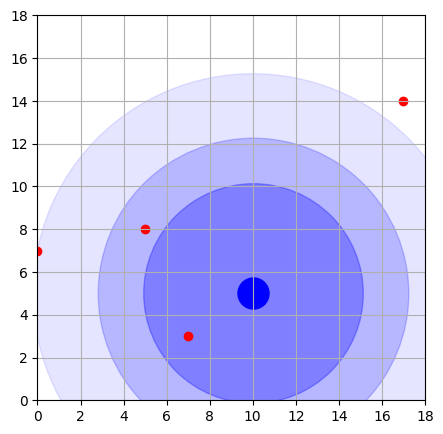

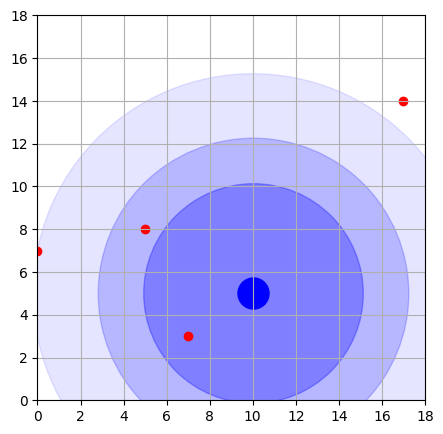

In [15]:
# =============================================================================
# this is the main function, run this cell!!!
# =============================================================================

model, results, v_res = dev_routine(model_kwargs=model_kwargs, train_kwargs=train_kwargs)


In [46]:
4//4

1

# Explainability

## Feature map

In [107]:
from visualisation.hook import Hook

import matplotlib.pyplot as plt
import numpy as np

import torch

from PIL import Image

import random


class FeatureMap2():
    # =============================================================================
    # ??? https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
    # ??? https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c
    # https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/4
    # =============================================================================

    def __init__(self, model, layer, device="cpu", ckpt_net_path=None, iterations=200, lr=1):
        # =============================================================================
        # Initialise iter, lr, model, layer
        # =============================================================================

        # settings for dreams
        self.iterations=iterations
        self.lr=lr
        self.device = device

        # model
        if ckpt_net_path is not None:
            model.load_state_dict(torch.load(ckpt_net_path)["model"]) # 'dir/decentnet_epoch_19_0.3627.ckpt'
        self.model = model.eval()
        
        # the (conv) layer to be visualised
        self.layer = layer
        print("")
        print("Layer:", self.layer)
        print("")

    def run(self, img_tensor):
        # =============================================================================
        # Feature map visualisation using hooks       
        # A high activation means a certain feature was found. 
        # A feature map is called the activations of a layer after the convolutional operation.
        # =============================================================================
        
        #print("i", img_tensor.data.shape)
        self.ii = img_tensor.data
            
        # hook = Hook(module=self.layer)
        
        active = {}
        def get_active(name):
            def hook(model, input, output): # hi
                active[name] = output.data.detach()
            return hook


        model = self.model
        model.model.decent2.register_forward_hook(get_active('model.model.decent2'))
        
        
        output = self.model(img_tensor, mode='explain')
        
        
        self.feature_maps = active['model.model.decent2']

        print('self.feature_maps', self.feature_maps.data.shape)
        
        '''
        output = self.model(img_tensor, mode='explain')
        self.feature_maps = hook.output.data # .squeeze()
        
        print('o', output.shape)
        print('i', self.ii.shape)
        print('h', hook.output)
        print('f', self.feature_maps.shape)
        '''
        
        

    def plot(self, path=None):
        # =============================================================================
        # plot 15 random feature maps + original image
        # =============================================================================
        
        # plt.figure(figsize=(100,100))
        amount = self.feature_maps.shape[1]
        print("amount of feature maps:", amount)
        if amount < 16:
            sample_amount = amount
        else:
            sample_amount = 16
        
        x_axis = amount//4
        if x_axis == 1: x_axis = 2
        fig, axarr = plt.subplots(x_axis, 4)
            
        
        random_samples = random.sample(range(0, amount), sample_amount)
        print("random_samples", random_samples)
        counter = 0  
        idx,idx2 = [0, 0]
        for idx in range(0, 4):
            if int(counter) >= int(sample_amount):
                break
            for idx2 in range(0, 4):
                if int(counter) >= int(sample_amount):
                        break
                axarr[idx, idx2].axis('off')
                try:
                    print(self.feature_maps.squeeze().shape)
                    print("try 1")
                    axarr[idx, idx2].imshow(self.feature_maps.squeeze()[random_samples[counter]].cpu().detach().numpy())
                    counter += 1
                    
                except:
                    try:
                        print("try 2")
                        axarr[idx, idx2].imshow(self.feature_maps.cpu().detach().numpy())
                        counter += 1
                    except:
                        try:
                            print("try 3")
                            axarr[idx, idx2].imshow( (self.feature_maps.squeeze()[random_samples[counter]]).cpu().detach().numpy().transpose(1, 2, 0))
                        except Exception as e:
                            print("not possible to show feature maps image")
                            print(self.feature_maps.shape)
                            print(e)
            

        # overwrite first image with original image
        try:
            axarr[idx,idx2].imshow(self.ii.cpu().detach().numpy().transpose(1, 2, 0))
        except:
            try:
                axarr[idx,idx2].imshow(self.ii.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
            except:
                try: 
                    axarr[idx,idx2].imshow(self.ii.squeeze(1).cpu().detach().numpy().transpose(1, 2, 0))
                except Exception as e:
                    print("not possible to show original image")
                    print(e)
        
        if path is not None:
            fig.savefig(path)
        else:
            plt.show()
        
        # print(self.ii.shape)
        # plt.imshow(self.ii.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
    

    
    
    
    
    
    



In [108]:
def run_explain(model, layer, device='cuda'):

    ichallenge_data = torchvision.datasets.ImageFolder('examples/example_data/eye')
    img, label = ichallenge_data.__getitem__(1)

    # tensor preparation
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize(28)
    img = to_tensor(img)
    img = resize(img)
    
    tmp = torch.autograd.Variable(torch.randn(1, 1, 28, 28)) # batch x channel x width x height
    # dense_input.shape

    # todo: ms need to have same size as channel

    img = X(img.unsqueeze(0), [torch.tensor(0)], [torch.tensor(0)])
    
    print(img.data.shape)
    
    # run feature map
    dd = FeatureMap2(model=model, layer=layer, device=device, iterations=10, lr=0.1)
    dd.run(img)
    dd.plot()

## run explainability ****************************

In [109]:
# nothing yet - currently part of the main running dev thingi

torch.Size([1, 3, 28, 28])

Layer: DecentLayer(
  (filter_list): ModuleList(
    (0): DecentFilter(weights: torch.Size([1, 3, 3, 3]) at position: m_this=Parameter containing:
    tensor([10.]), n_this=Parameter containing:
    tensor([5.]))
     with inputs: ms_in= 10, 1, 2, ns_in= 10, 6, 1)
    (1): DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
    tensor([13.]), n_this=Parameter containing:
    tensor([0.]))
     with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)
    (2): DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
    tensor([13.]), n_this=Parameter containing:
    tensor([6.]))
     with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)
    (3): DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
    tensor([9.]), n_this=Parameter containing:
    tensor([7.]))
     with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)
  )
)

self.feature_maps torch.Size(

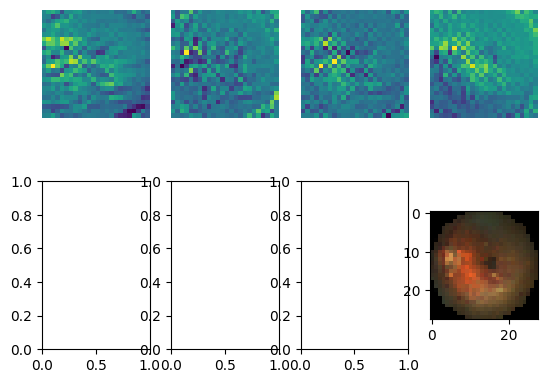

In [110]:
layer = model.model.decent2 # .filter_list[7]weights
run_explain(model, layer, device='cuda')

In [21]:
model

DecentLightning(
  (model): DecentNet(
    (decent1): DecentLayer(
      (filter_list): ModuleList(
        (0): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([10.]), n_this=Parameter containing:
        tensor([10.]))
         with inputs: ms_in= 0, ns_in= 0)
        (1): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([1.]), n_this=Parameter containing:
        tensor([6.]))
         with inputs: ms_in= 0, ns_in= 0)
        (2): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([2.]), n_this=Parameter containing:
        tensor([1.]))
         with inputs: ms_in= 0, ns_in= 0)
        (3): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
        tensor([13.]), n_this=Parameter containing:
        tensor([11.]))
         with inputs: ms_in= 0, ns_in= 0)
      )
    )
    (decent2):

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 3, 3, 3]) at position: m_this=Parameter containing:
tensor([10.]), n_this=Parameter containing:
tensor([5.]))
 with inputs: ms_in= 10, 1, 2, ns_in= 10, 6, 1)

self.feature_maps torch.Size([1, 4, 24, 24])
amount of feature maps: 4
random_samples [2, 0, 1, 3]
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24,

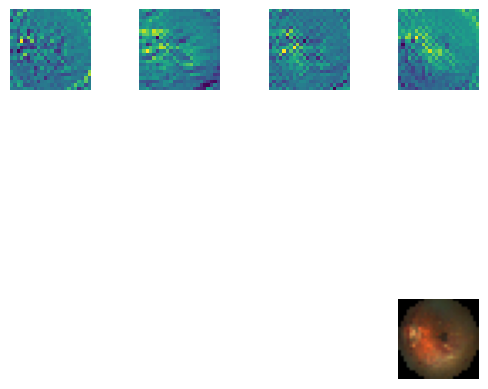

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
tensor([13.]), n_this=Parameter containing:
tensor([0.]))
 with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)

self.feature_maps torch.Size([1, 4, 24, 24])
amount of feature maps: 4
random_samples [0, 2, 3, 1]
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size

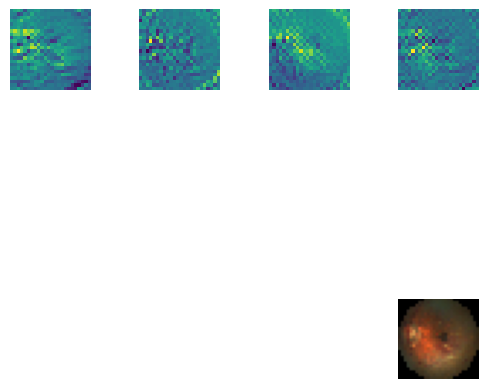

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
tensor([13.]), n_this=Parameter containing:
tensor([6.]))
 with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)

self.feature_maps torch.Size([1, 4, 24, 24])
amount of feature maps: 4
random_samples [1, 0, 3, 2]
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size

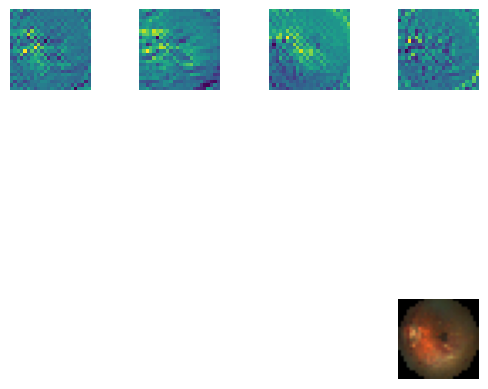

torch.Size([1, 3, 28, 28])

Layer: DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
tensor([9.]), n_this=Parameter containing:
tensor([7.]))
 with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)

self.feature_maps torch.Size([1, 4, 24, 24])
amount of feature maps: 4
random_samples [0, 3, 1, 2]
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size([4, 24, 24])
try 1
try 2
try 3
not possible to show feature maps image
torch.Size([1, 4, 24, 24])
list index out of range
torch.Size(

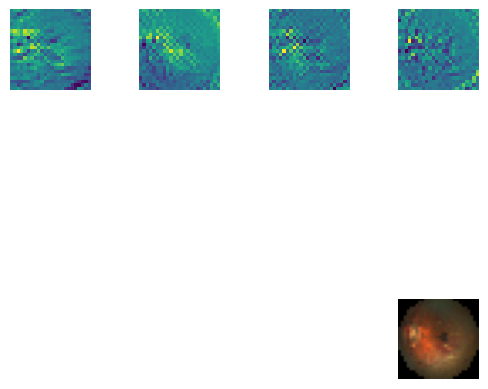

In [22]:
import torchvision

for l in range(100):
    try:
        layer = model.model.decent2.filter_list[l] # .filter_list[7]weights
        run_explain(model, layer, device='cuda')
    except:
        pass

torch.Size([1, 3, 28, 28])

Layer: DecentLayer(
  (filter_list): ModuleList(
    (0): DecentFilter(weights: torch.Size([1, 3, 3, 3]) at position: m_this=Parameter containing:
    tensor([10.]), n_this=Parameter containing:
    tensor([5.]))
     with inputs: ms_in= 10, 1, 2, ns_in= 10, 6, 1)
    (1): DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
    tensor([13.]), n_this=Parameter containing:
    tensor([0.]))
     with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)
    (2): DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
    tensor([13.]), n_this=Parameter containing:
    tensor([6.]))
     with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)
    (3): DecentFilter(weights: torch.Size([1, 4, 3, 3]) at position: m_this=Parameter containing:
    tensor([9.]), n_this=Parameter containing:
    tensor([7.]))
     with inputs: ms_in= 10, 1, 2, 13, ns_in= 10, 6, 1, 11)
  )
)

self.feature_maps torch.Size(

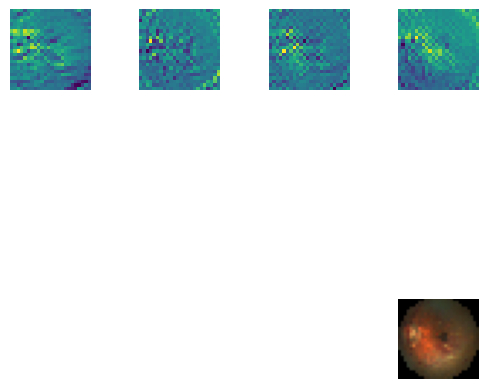

In [23]:
import torchvision
layer = model.model.decent2 # .filter_list[7]weights
run_explain(model, layer, device='cuda')

In [24]:
results

{'test accuracy on valset': 0.20000000298023224}

In [25]:
v_res

[{'test_acc': 0.20000000298023224,
  'test_f1': 0.20000000298023224,
  'test_prec': 0.0573626384139061,
  'test_loss': 3.3609848022460938,
  'test_cc': 4.862654877758758}]

In [26]:
torch.load("example_results/lightning_logs/tmp/version_22/checkpoints/epoch=4-unpruned=10815-val_f1=0.12.ckpt").keys()

FileNotFoundError: [Errno 2] No such file or directory: 'example_results/lightning_logs/tmp/version_22/checkpoints/epoch=4-unpruned=10815-val_f1=0.12.ckpt'

In [ ]:
torch.load("example_results/lightning_logs/tmp/version_22/checkpoints/epoch=4-unpruned=10815-val_f1=0.12.ckpt")['loops'].keys()

In [ ]:
torch.load("example_results/lightning_logs/tmp/version_22/checkpoints/epoch=4-unpruned=10815-val_f1=0.12.ckpt")['state_dict'].keys()